In [25]:
import torch
import numpy as np
import pickle


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import gym_sin
from gym import spaces

from network.vae import InferenceNetworkDirectlyRec
from active_learning.PosteriorTS import PosteriorTSAgent
from task.GuassianTaskGenerator import GaussianTaskGenerator

In [27]:
def get_const_task_sequence_prior(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-10], [5]], dtype=torch.float32) for _ in range(num_test_processes)]
        
    mean = -5
    std = 15
    
    prior_seq = []
    for idx in range(50):
        p = torch.tensor([[mean], [0.1]], dtype=torch.float32)
        prior_seq.append(p)

    return gp_list, prior_seq, init_prior_test

def get_const_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-10], [5]], dtype=torch.float32) for _ in range(num_test_processes)]
        
    mean = -5
    std = 15
    
    for idx in range(50):
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

def get_linear_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(50):
        std = 15
        mean = 30 - idx
        
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

def get_phase_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-5], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(50):
        if idx < 15:
            std = 15
            mean = 0
        elif idx < 30:
            std = 15
            mean = 10
        else:
            std = 15
            mean = 0
            
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

def get_abrupt_and_smooth(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(80):
        if idx < 15:
            std = 15
            mean = -30
        elif idx < 50:
            std = 15
            mean = -20 + (idx - 15)
        else:
            std = 15
            mean = -20 + 50 - 15 

            
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test


In [28]:
env_name = "gauss-v0"

action_space = spaces.Box(low=np.array([-1]), high=np.array([1]))
latent_dim = 1

x_min = -100
x_max = 100

min_mean = -40
max_mean = 40

prior_mu_min = -10
prior_mu_max = 10
prior_std_min = 1
prior_std_max = 10

std = 5
amplitude=1

device = "cpu"

task_generator = GaussianTaskGenerator(x_min, x_max, min_mean, max_mean,
                 prior_mu_min, prior_mu_max, prior_std_min, prior_std_max, std, amplitude)
fam = task_generator.create_task_family(n_tasks=5000, n_batches=1, test_perc=0, batch_size=1)

In [29]:
vi = InferenceNetworkDirectlyRec(n_in=4, z_dim=latent_dim)
vi_optim = torch.optim.Adam(vi.parameters(), lr=1e-3)

In [30]:
num_steps = 150
num_processes = 32
device = "cpu"
gamma = 1
latent_dim = 1
use_env_obs = False
min_action = -100
max_action = 100
max_sigma = 10

agent = PosteriorTSAgent(vi, vi_optim, num_steps, num_processes, device, gamma, latent_dim,
                 use_env_obs, min_action, max_action, max_sigma)

In [31]:
n_train_iter = 5000
eval_interval = 20
env_name = "gauss-v0"
seed = 0
log_dir = "."
verbose = True
num_random_task_to_evaluate = 32
num_eval_processes = 2
use_true_sigma = True
sw_size = 10

gp_list, prior_seq, init_prior_test = get_const_task_sequence_prior(0.25, 1, 2)
    
t = agent.train(n_train_iter, eval_interval, task_generator, env_name, seed, log_dir, verbose,
              num_random_task_to_evaluate, [gp_list], sw_size, [prior_seq],
              [init_prior_test], num_eval_processes, use_true_sigma)

Iteration 0 / 5000
Evaluation using 32 tasks. Mean reward: 25.497343218749997
Meta-testing...
Using GP 10.49166995
Meta-testing...
Using real prior 10.37396099
Iteration 20 / 5000
Evaluation using 32 tasks. Mean reward: 9.60029975
Meta-testing...
Using GP 11.16798992
Meta-testing...
Using real prior 21.13321826
Iteration 40 / 5000
Evaluation using 32 tasks. Mean reward: 9.465319375
Meta-testing...
Using GP 12.398789899999999
Meta-testing...
Using real prior 45.62016696999999
Iteration 60 / 5000
Evaluation using 32 tasks. Mean reward: 17.50652378125
Meta-testing...
Using GP 18.637828319999997
Meta-testing...
Using real prior 102.64915927
Iteration 80 / 5000
Evaluation using 32 tasks. Mean reward: 35.762230906250004
Meta-testing...
Using GP 138.49045318
Meta-testing...
Using real prior 143.9953306
Iteration 100 / 5000
Evaluation using 32 tasks. Mean reward: 37.85986134375
Meta-testing...
Using GP 109.55694450000001
Meta-testing...
Using real prior 134.70199003
Iteration 120 / 5000
Evalua

Using real prior 144.58686412
Iteration 1000 / 5000
Evaluation using 32 tasks. Mean reward: 89.52045165625
Meta-testing...
Using GP 126.99869301999999
Meta-testing...
Using real prior 144.17948610000002
Iteration 1020 / 5000
Evaluation using 32 tasks. Mean reward: 94.32766103125
Meta-testing...
Using GP 3.7953143099999993
Meta-testing...
Using real prior 141.2520446
Iteration 1040 / 5000
Evaluation using 32 tasks. Mean reward: 72.54697615625
Meta-testing...
Using GP 10.033105640000002
Meta-testing...
Using real prior 142.65089104
Iteration 1060 / 5000
Evaluation using 32 tasks. Mean reward: 98.90910115625
Meta-testing...
Using GP 2.635970680000001
Meta-testing...
Using real prior 139.45050566999998
Iteration 1080 / 5000
Evaluation using 32 tasks. Mean reward: 81.78954487499999
Meta-testing...
Using GP 34.43936509
Meta-testing...
Using real prior 143.00958586
Iteration 1100 / 5000
Evaluation using 32 tasks. Mean reward: 82.3462154375
Meta-testing...
Using GP 90.00652325000001
Meta-testi

Iteration 1980 / 5000
Evaluation using 32 tasks. Mean reward: 101.71334246875
Meta-testing...
Using GP 30.252209390000004
Meta-testing...
Using real prior 143.52594947
Iteration 2000 / 5000
Evaluation using 32 tasks. Mean reward: 91.18566259375001
Meta-testing...
Using GP 101.34799167999999
Meta-testing...
Using real prior 143.35271142000002
Iteration 2020 / 5000
Evaluation using 32 tasks. Mean reward: 94.070695375
Meta-testing...
Using GP 110.13971333
Meta-testing...
Using real prior 144.64869648
Iteration 2040 / 5000
Evaluation using 32 tasks. Mean reward: 100.00559803125
Meta-testing...
Using GP 18.64445273
Meta-testing...
Using real prior 144.83028760000002
Iteration 2060 / 5000
Evaluation using 32 tasks. Mean reward: 95.975149625
Meta-testing...
Using GP 63.231510420000006
Meta-testing...
Using real prior 144.84276631
Iteration 2080 / 5000
Evaluation using 32 tasks. Mean reward: 93.8128925625
Meta-testing...
Using GP 135.6508052
Meta-testing...
Using real prior 144.60665343
Iterat

Using GP 79.46603927999999
Meta-testing...
Using real prior 142.68174596000003
Iteration 2980 / 5000
Evaluation using 32 tasks. Mean reward: 96.6592735625
Meta-testing...
Using GP 63.13397352000002
Meta-testing...
Using real prior 142.90725956
Iteration 3000 / 5000
Evaluation using 32 tasks. Mean reward: 106.3120841875
Meta-testing...
Using GP 40.520735089999995
Meta-testing...
Using real prior 141.49710874000002
Iteration 3020 / 5000
Evaluation using 32 tasks. Mean reward: 108.268792
Meta-testing...
Using GP 30.901358519999995
Meta-testing...
Using real prior 142.80443701000002
Iteration 3040 / 5000
Evaluation using 32 tasks. Mean reward: 95.96040534375001
Meta-testing...
Using GP 127.47433506000002
Meta-testing...
Using real prior 143.16996288
Iteration 3060 / 5000
Evaluation using 32 tasks. Mean reward: 110.66356418749999
Meta-testing...
Using GP 102.08465557999997
Meta-testing...
Using real prior 141.97892015
Iteration 3080 / 5000
Evaluation using 32 tasks. Mean reward: 100.1047379

Iteration 3960 / 5000
Evaluation using 32 tasks. Mean reward: 123.62797228125
Meta-testing...
Using GP 45.92346111999999
Meta-testing...
Using real prior 142.37421306
Iteration 3980 / 5000
Evaluation using 32 tasks. Mean reward: 95.32959059375
Meta-testing...
Using GP 71.19286444000001
Meta-testing...
Using real prior 142.67648714
Iteration 4000 / 5000
Evaluation using 32 tasks. Mean reward: 105.81386209374999
Meta-testing...
Using GP 43.88764779000001
Meta-testing...
Using real prior 142.12026224
Iteration 4020 / 5000
Evaluation using 32 tasks. Mean reward: 126.24923303125
Meta-testing...
Using GP 74.44387666
Meta-testing...
Using real prior 143.29990487
Iteration 4040 / 5000
Evaluation using 32 tasks. Mean reward: 119.97864743749999
Meta-testing...
Using GP 61.80583123
Meta-testing...
Using real prior 143.29530347
Iteration 4060 / 5000
Evaluation using 32 tasks. Mean reward: 100.11633828125
Meta-testing...
Using GP 72.65623992
Meta-testing...
Using real prior 143.24836157
Iteration 4

Using GP 14.49371976
Meta-testing...
Using real prior 144.41638475999997
Iteration 4960 / 5000
Evaluation using 32 tasks. Mean reward: 101.03068025
Meta-testing...
Using GP 130.53192212000002
Meta-testing...
Using real prior 143.67991628
Iteration 4980 / 5000
Evaluation using 32 tasks. Mean reward: 104.93600209375
Meta-testing...
Using GP 104.41363632000001
Meta-testing...
Using real prior 142.64725012


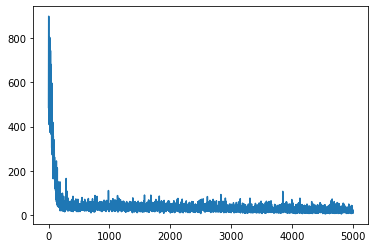

In [35]:
plt.plot(t[0])

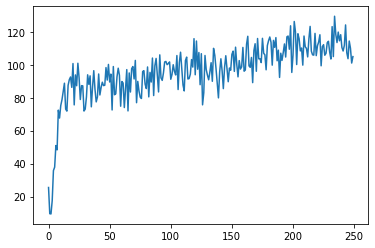

In [36]:
plt.plot(t[1])

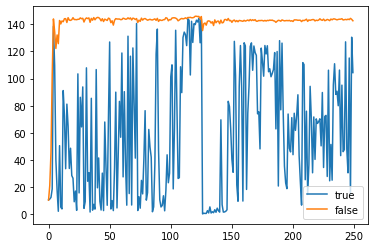

In [44]:
use_true = [t[2][i][0] for i in range(len(t[2]))]
use_false = [t[2][i][1] for i in range(len(t[2]))]
plt.plot(use_true, label="true")
plt.plot(use_false, label="false")
plt.legend()
plt.show()